In [ ]:
import numpy as np

: 

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

: 

# Load experiments

In [2]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.amplitude_rabi_ef
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.ramsey_ef
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy
impo

In [3]:
save_data = True

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# expt_path=os.getcwd()+'\data_220623'
# expt_path=os.getcwd()+'\data_220712'
# expt_path=os.getcwd()+'\data_220801'
# expt_path=os.getcwd()+'\data_220904'
# expt_path=os.getcwd()+'\data_220919'
# expt_path=os.getcwd()+'\data_220929'
# expt_path=os.getcwd()+'\data_221007'
expt_path=os.getcwd()+'\data_221020'
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data_221020


In [6]:
# config_file = 'config_zcu216.yml'
config_file = 'config_q3diamond.yml'
config_path = os.getcwd() + '\\' + config_file
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond.yml


Load config

In [7]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Qubit/resonator to probe

In [8]:
all_results = [dict(), dict(), dict(), dict()]
saved_files = []

In [100]:
qubit_i = 0
results_Qi = all_results[qubit_i]

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [101]:
im = InstrumentManager(ns_address='192.168.14.1')

In [37]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print(f'set freq to [MHz] {lo_freq*1e-6}')
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to [MHz] 5925.0
set power to 7.0


In [102]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_sg_mux4_v2 - tProc output 6, envelope mem

In [40]:
# print(list(im))
# print(im)

# RFSoC Calibration

In [46]:
tof = meas.ToFCalibrationExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"adc_trig_offset_calibration_qubit{qubit_i}",
    config_file=config_path,
)

tof.cfg.expt = dict(
    pulse_length=0.5, # [us]
    readout_length=1.0, # [us]
    trig_offset=0, # [clock ticks]
    # gain=32000,
    gain=1.0, # [MUX units: -1 to 1]
    frequency=tof.cfg.device.readout.frequency[qubit_i], # [MHz]
    reps=2000, # Number of averages per point
    # qubit=qubit_i,
    qubit=qubit_i,
)
tof.cfg.device.readout.relax_delay=0.1 # wait time between experiments [us]
# print(tof.cfg)

import Pyro4.util
try:
    tof.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

215 307
readout freq 950 +/- -808.35


  0%|          | 0/2000 [00:00<?, ?it/s]

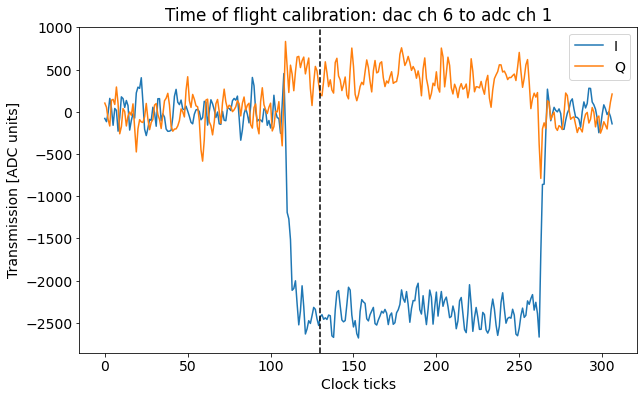

In [47]:
tof.display(adc_trig_offset=130)

# Initial single tone resonator spectroscopy

In [103]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
rspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 2.5 # MHz
npts = 100
rspec.cfg.expt = dict(
    start=rspec.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=1000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec.cfg.device.readout.gain = 0.850
rspec.cfg.device.readout.relax_delay = 5 # Wait time between experiments [us]

import Pyro4.util
try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

  0%|          | 0/100 [00:00<?, ?it/s]

[814.0564999999999, 5000, 1000, 0, 115.66022016048021, 366.874602351058]
[ 8.14680970e+02  5.74713680e+03  6.46369387e+05 -1.11534783e+00
  1.21437329e+04 -1.17696412e+04]

Freq with minimum transmission: 814.644
Freq with maximum transmission: 814.819
From fit:
	f0: 814.680970074201
	Qi: 5747.136801734536
	Qe: 646369.3866260645
	Q0: 5696.486986507904
	kappa [MHz]: 0.1430146284901147
	phi [radians]: -1.1153478250565896


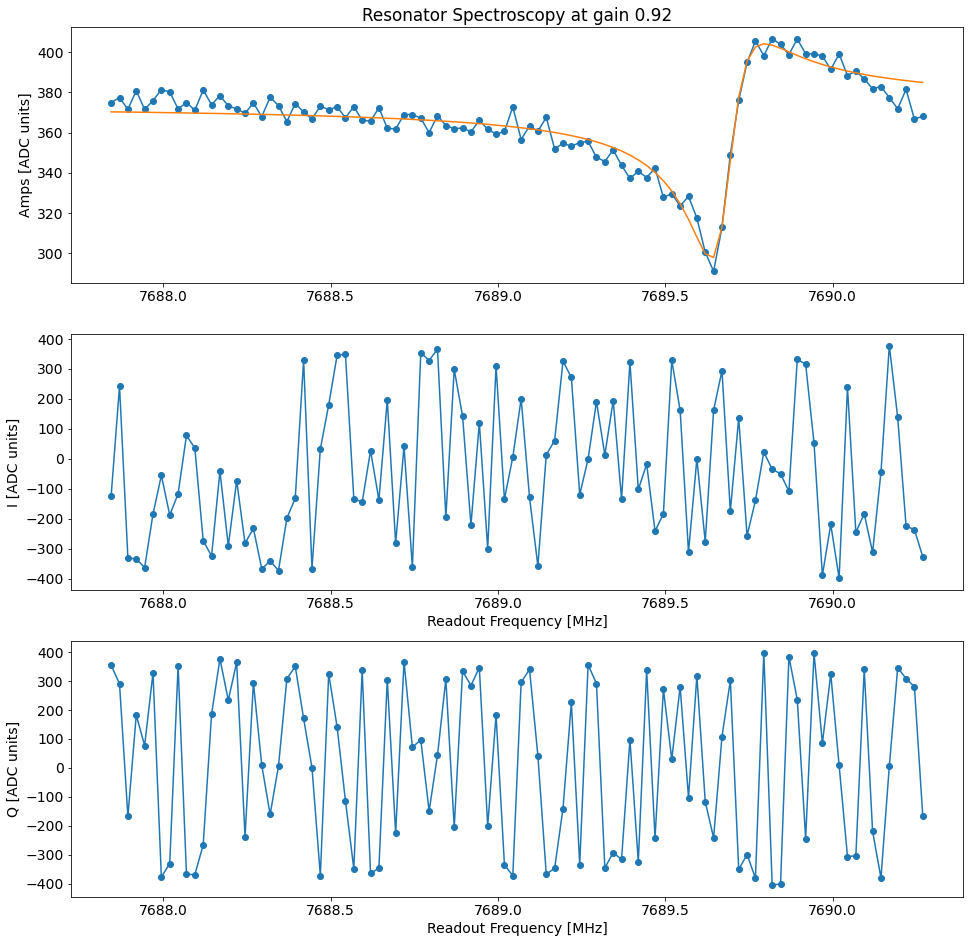

*Set cfg res 0 freq to 814.644*
*Set cfg res 0 gain to 0.92*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [104]:
 # TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.analyze(fit=True)
rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)
# yaml_cfg.device.readout.frequency[qubit_i] = rspec_fit[0]
yaml_cfg.device.readout.frequency[qubit_i] = rspec.data['xpts'][np.argmin(rspec.data['amps'])]
yaml_cfg.device.readout.gain[qubit_i] = rspec.cfg.device.readout.gain
print(f'*Set cfg res {qubit_i} freq to {yaml_cfg.device.readout.frequency[qubit_i]}*')
print(f'*Set cfg res {qubit_i} gain to {yaml_cfg.device.readout.gain[qubit_i]}*')
results_Qi.update({'Res freq':float(yaml_cfg.hw.lo.readout.frequency)*1e-6 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.device.readout.frequency[qubit_i] + yaml_cfg.hw.soc.dacs.readout.mixer_freq)})
results_Qi.update({'Res kappa':abs(rspec_fit[0]*(1/rspec_fit[1] + 1/rspec_fit[2]))})
print(all_results)

In [105]:
if save_data: saved_files.append(rspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_resonator_spectroscopy_qubit0.h5


# Qubit ge spectroscopy

## Pulse Probe (qubit) spectroscopy

In [106]:
qspec = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 200
npts = 200

qspec.cfg.expt = dict(
    start=qspec.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 813.3161120126341, HWHM -2.612643426076097
Found peak in I at [MHz] 879.2122120203194, HWHM -1.6533788299039422
Found peak in Q at [MHz] 813.3270456121647, HWHM -2.6984794611692067


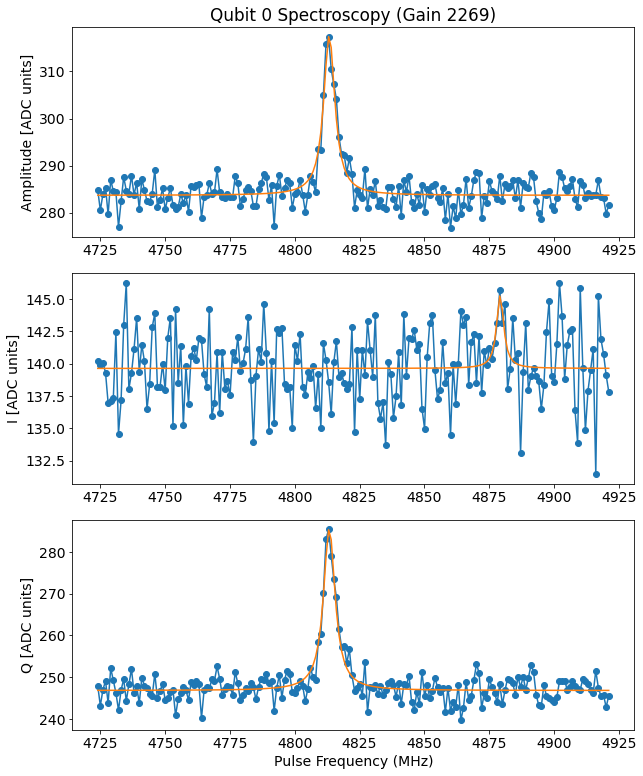

*Set qubit 0 f_ge to 813.3270456121647*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4813.3270456121645}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [107]:
# # TESTING
# # qspec = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qspec.data['fit_err_avgi'][2][2]
        fit_err_q = qspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec.analyze(fit=True, signs=best_signs)
qspec.display(fit=True, signs=best_signs)

qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data, compare_param_i=1)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec_fit[2]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [108]:
if save_data: saved_files.append(qspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_qubit_spectroscopy_qubit0.h5


## Pulse Probe (qubit) spectroscopy round 2

In [109]:
qspec2 = meas.PulseProbeSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50
npts = 150

qspec2.cfg.expt = dict(
    start=qspec2.cfg.device.qubit.f_ge[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=100, # Number of averages per point
    rounds=20, # Number of start to finish sweeps to average over
    length=10, # Qubit probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]/10), # Qubit pulse gain
    qubit=qubit_i,
)
qspec2.cfg.device.readout.relax_delay = 10 # Wait time between experiments [us]
qspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

Found peak in amps at [MHz] 812.5110934096341, HWHM 2.4552960077838204
Found peak in I at [MHz] 813.4581562038528, HWHM 6.843160484047659
Found peak in Q at [MHz] 812.5087958064922, HWHM 2.5175594543451116


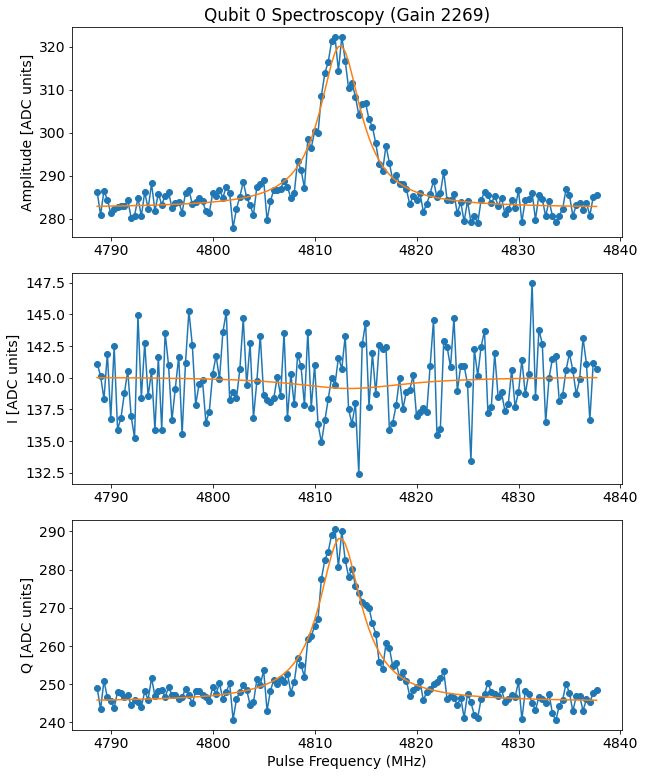

*Set qubit 0 f_ge to 812.5087958064922*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.508795806492}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [110]:
# # TESTING
# # qspec2 = meas.PulseProbeSpectroscopyExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00001_qubit_spectroscopy_qubit0.h5')
# qspec2.data = temp_data

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qspec2.analyze(fit=True, signs=[1, sign, sign])
        fit_err_amps = qspec2.data['fit_err_amps'][2][2]
        fit_err_i = qspec2.data['fit_err_avgi'][2][2]
        fit_err_q = qspec2.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qspec2.analyze(fit=True, signs=best_signs)
qspec2.display(fit=True, signs=best_signs)

qspec2_fit, qspec2_fit_err = meas.fitting.get_best_fit(qspec2.data, compare_param_i=1)
yaml_cfg.device.qubit.f_ge[qubit_i] = qspec2_fit[2]
qubit_hwhm = qspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ge to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')

results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [111]:
if save_data: saved_files.append(qspec2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00001_qubit_spectroscopy_qubit0.h5


## Length Rabi

In [112]:
lengthrabi = meas.LengthRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_qubit{qubit_i}",
    config_file=config_path,
)
lengthrabi.cfg = AttrDict(deepcopy(yaml_cfg))

lengthrabi.cfg.expt = dict(
    start=0, # pulse length (sigma) [us]
    step=soc.cycles2us(1), # [us]
    # step=0.001,
    expts=151,
    reps=3000,
    gain=20000, # qubit gain [DAC units],
    pulse_type='gauss',
    qubit=qubit_i,
)
lengthrabi.cfg.device.readout.relax_delay = 50 # Wait time between experiments [us]
lengthrabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

Decay from avgi [us] 0.3113835812802334
Pi length from avgi data [us]: 0.039959343699903796
	Pi/2 length from avgi data [us]: 0.019979671849951898

Decay from avgq [us] 1.2012801755538491
Pi length from avgq data [us]: 0.05105997839239446
Pi/2 length from avgq data [us]: 0.02552998919619723


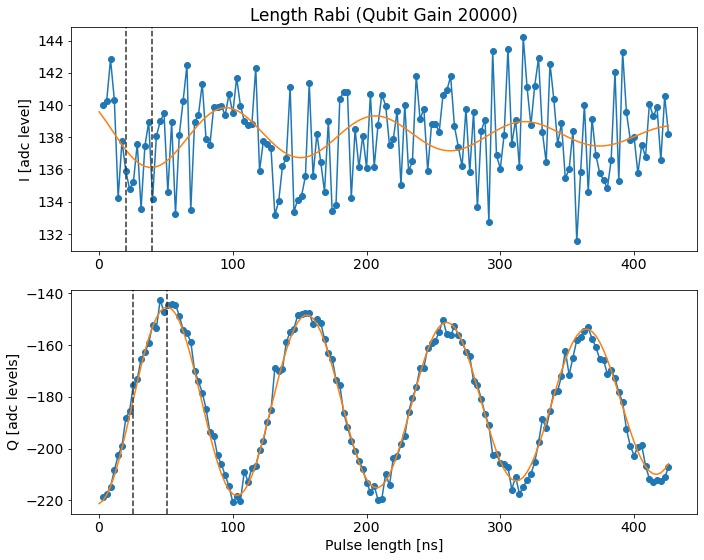

Will use sigma 0.03596340932991342 for amplitude rabi


In [113]:
# # TESTING
# # lengthrabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# lengthrabi.data = temp_data

lengthrabi.analyze(fit=True)

lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabi.data, compare_param_i=1)

lengthrabi.display(fit=True)
p = lengthrabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
else: pi_len = (3/2 - p[2]/180)/2/p[1]
pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain

lengthrabi_decay = p[3]

print(f'Will use sigma {pi_len} for amplitude rabi')

In [114]:
if save_data: saved_files.append(lengthrabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_length_rabi_qubit0.h5


## Amplitude Rabi

In [115]:
amprabi = meas.AmplitudeRabiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"amp_rabi_qubit{qubit_i}",
    config_file=config_path,
)
amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 151
    
amprabi.cfg.expt = dict(
    start=0, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
    pulse_type='gauss',
    qubit=qubit_i,
)
amprabi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 0.0010110584518167457, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Attempted to init fitparam 1 to 0.0017377567140600316, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
Attempted to init fitparam 1 to 0.0013902053712480254, which is out of bounds 3.1807627469067084e-06 to 0.0004771144120360062. Instead init to 0.00024014758739145645
2


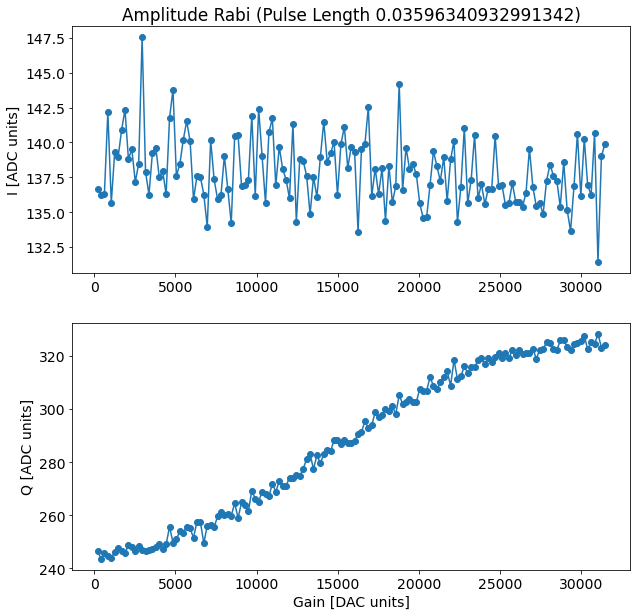

*Set pi pulse sigma for qubit 0 to 0.03596340932991342*
*Set pi pulse gain for qubit 0 to 30000*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.508795806492, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [116]:
# # TESTING
# # amprabi = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_qubit0.h5')
# amprabi.data = temp_data

amprabi.analyze(fit=True)

amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data, compare_param_i=2, override='avgq')

p = amprabi_fit
if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabi.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabi.display(fit=True)
yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i] = amprabi.cfg.expt.sigma_test

print(f'*Set pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(pi_gain)
print(f'*Set pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]}*')
results_Qi.update({'Pi pulse len':yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]})
results_Qi.update({'Pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]})
print(all_results)

In [117]:
if save_data: saved_files.append(amprabi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_amp_rabi_qubit0.h5


## $T_1$

In [118]:
# if lengthrabi_decay < 10: short_T1 = True
# else: short_T1 = False
short_T1 = False

In [119]:
t1 = meas.T1Experiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"t1_qubit{qubit_i}",
    config_file=config_path,
)
t1.cfg = AttrDict(deepcopy(yaml_cfg))

span = 50 if short_T1 else 300
npts = 151

t1.cfg.expt = dict(
    start=0, # wait time [us]
    step=span/npts,
    expts=npts,
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t1.cfg.device.readout.relax_delay = span # Wait time between experiments [us]
t1.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

c:\Users\slab\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
s:\Connie\experiments\qramLL_4QR2\experiments\fitting.py:35: RuntimeWarning: overflow encountered in exp
  return y0 + yscale*np.exp(-(x-x0)/decay)


Fit T1 avgi [us]: 548.7839340921038
Fit T1 avgq [us]: 20.68756295371525


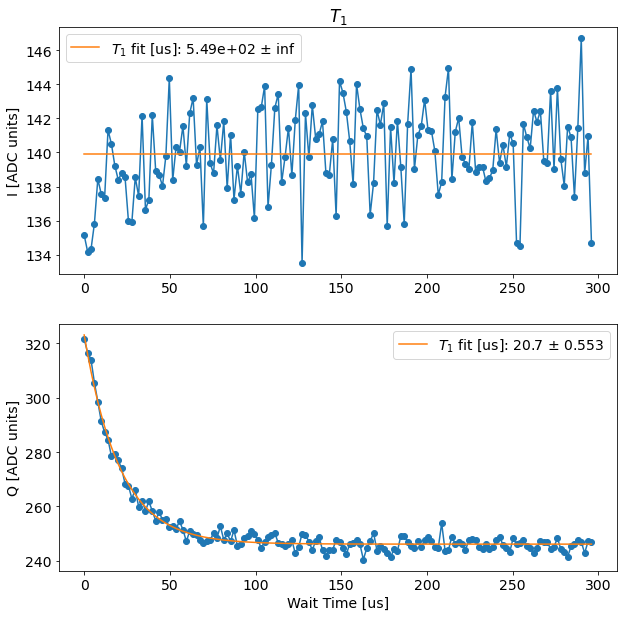

*Set qubit 0 T1 to 20.0*
*Set readout 0 relax delay to 61.0*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.508795806492, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000, 'T1': 20.27627011263198, 'T1 err': 0.5826490416084753}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [120]:
# # TESTING
# # t1 = meas.T1Experiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_t1_qubit1.h5')
# t1.data = temp_data

t1.analyze(fit=True)

t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data, compare_param_i=3)

t1.display(fit=True)
yaml_cfg.device.qubit.T1[qubit_i] = np.round(t1_fit[3])
yaml_cfg.device.readout.relax_delay[qubit_i] = np.round(3*t1_fit[3])
print(f'*Set qubit {qubit_i} T1 to {yaml_cfg.device.qubit.T1[qubit_i]}*')
print(f'*Set readout {qubit_i} relax delay to {yaml_cfg.device.readout.relax_delay[qubit_i]}*')
results_Qi.update({'T1':t1_fit[3], 'T1 err':np.sqrt(t1_fit_err[3][3])})
print(all_results)

In [121]:
if save_data: saved_files.append(t1.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_t1_qubit0.h5


## $T_2$ Ramsey round 1

In [122]:
ramsey_freq = max(min(np.abs(np.ceil(qubit_hwhm)), 3), 2)
print(f'Ramsey freq [MHz]: {ramsey_freq}')

t2r = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us] 
    expts=151,
    ramsey_freq=ramsey_freq, # [MHz]
    reps=100,
    # reps=5,
    rounds=30,
    qubit=qubit_i,
)
t2r.go(analyze=False, display=False, progress=True, save=False)

Ramsey freq [MHz]: 3.0


  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 15.866508, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Current qubit frequency: 812.5087958064922
Fit frequency from I [MHz]: 1.6806153880109007 +/- 0.13996288083671665
Suggested new qubit frequency from fit I [MHz]:
 	813.8281804184813
 	807.8281804184813
T2 Ramsey from fit I [us]: 1.9006334531646245
Fit frequency from Q [MHz]: 2.8942745416918556 +/- 0.0031162507530134134
Suggested new qubit frequencies from fit Q [MHz]:
 	812.6145212648004
 	806.6145212648004
T2 Ramsey from fit Q [us]: 2.8689538473679885


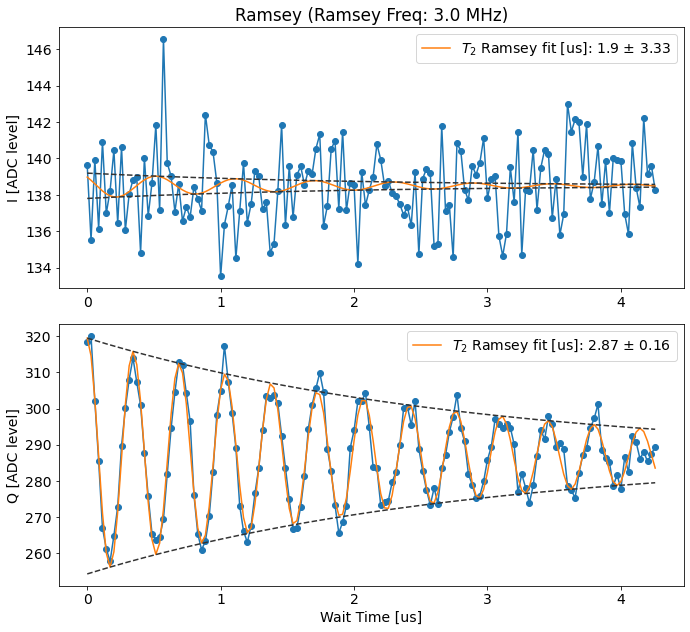

*Set qubit 0 freq to 812.6153050251032*
Alt qubit freq is 806.6153050251032


In [123]:
# # TESTING
# # t2r = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r.data = temp_data

t2r.analyze(fit=True)

t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

old_qubit_freq = t2r.cfg.device.qubit.f_ge
t2r.display(fit=True)
yaml_cfg.device.qubit.f_ge[qubit_i] = old_qubit_freq + t2r_adjust[0]
alt_qubit_freq = old_qubit_freq + t2r_adjust[1]
print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Alt qubit freq is {alt_qubit_freq}')

In [124]:
if save_data: saved_files.append(t2r.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_ramsey_qubit0.h5


## $T_2$ Ramsey round 2

Check that frequency adjustment helps.

In [125]:
t2r_2 = meas.RamseyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"ramsey_qubit{qubit_i}",
    config_file=config_path,
)
t2r_2.cfg = AttrDict(deepcopy(yaml_cfg))

# make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
t2r_2.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(2) if short_T1 else soc.cycles2us(60), # [us]
    expts=151,
    ramsey_freq=ramsey_freq/10, # [MHz]
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2r_2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 1.244432, which is out of bounds 0.0039149496644295305 to 0.5872424496644295. Instead init to 0.2955786996644295
Current qubit frequency: 812.6153050251032
Fit frequency from I [MHz]: 0.2841639414208971 +/- 0.013031980047065217
Suggested new qubit frequency from fit I [MHz]:
 	812.6311410836823
 	812.0311410836823
T2 Ramsey from fit I [us]: 13.882339763015562
Fit frequency from Q [MHz]: 0.2884797228992736 +/- 0.005222318474436533
Suggested new qubit frequencies from fit Q [MHz]:
 	812.626825302204
 	812.026825302204
T2 Ramsey from fit Q [us]: 2.583327254811115


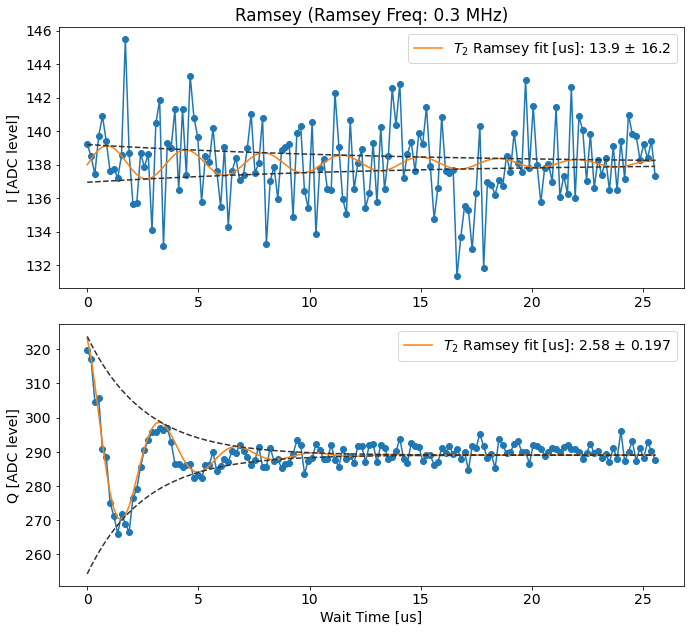

*Set qubit 0 freq to 812.626825302204*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.626825302204, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000, 'T1': 20.27627011263198, 'T1 err': 0.5826490416084753, 'T2R': 2.583327254811115, 'T2R err': 0.1974620102484872}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]
Redo T2R: False


In [126]:
# # TESTING
# # t2r_2 = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2r_2.data = temp_data

redo_t2r = True

t2r_2.analyze(fit=True)

t2r_2_fit, t2r_2_fit_err, t2r_2_adjust = meas.fitting.get_best_fit(t2r_2.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

t2r_2.display(fit=True)
final_qubit_freq = t2r_2.cfg.device.qubit.f_ge + t2r_2_adjust[0]
if abs(t2r_2_adjust[0]) <= abs(t2r_adjust[0]):
    redo_t2r = False
    yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
    results_Qi.update({'T2R':t2r_2_fit[3], 'T2R err':np.sqrt(t2r_2_fit_err[3][3])})
    results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
    print(all_results)
else: # redo_t2r = True
    yaml_cfg.device.qubit.f_ge[qubit_i] = alt_qubit_freq 
    print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
print(f'Redo T2R: {redo_t2r}')

In [127]:
if save_data: saved_files.append(t2r_2.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00001_ramsey_qubit0.h5


## $T_2$ Ramsey round 3

Run again in case adjust frequency in the wrong direction previously.

In [128]:
if redo_t2r:
    t2r_3 = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{qubit_i}",
        config_file=config_path,
    )
    t2r_3.cfg = AttrDict(deepcopy(yaml_cfg))

    # make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    t2r_3.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(2) if short_T1 else soc.cycles2us(10), # [us]
        expts=151,
        ramsey_freq=ramsey_freq/2, # [MHz]
        reps=100,
        # reps=10,
        rounds=30,
        qubit=qubit_i,
    )
    t2r_3.go(analyze=False, display=False, progress=True, save=False)

In [129]:
if redo_t2r:
    # # TESTING
    # # t2r_3 = meas.RamseyExperiment(config_file=config_path)
    # temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
    # t2r_3.data = temp_data

    t2r_3.analyze(fit=True)

    t2r_3_fit, t2r_3_fit_err, t2r_3_adjust = meas.fitting.get_best_fit(t2r_3.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

    if not isinstance(t2r_3_fit, (list, np.ndarray)):
        t2r_3.display(fit=True)
        final_qubit_freq = t2r_3.cfg.device.qubit.f_ge + t2r_3_adjust[0]
        if abs(t2r_3_adjust[0]) <= abs(t2r_adjust[0]):
            yaml_cfg.device.qubit.f_ge[qubit_i] = final_qubit_freq
            print(f'*Set qubit {qubit_i} freq to {yaml_cfg.device.qubit.f_ge[qubit_i]}*')
            i_best = np.argmin([t2r_fit_err[3][3], t2r_3_fit_err[3][3]])
            results_Qi.update({'T2':[t2r_fit[3], t2r_3_fit[3]][i_best], 'T2 err':np.sqrt([t2r_fit_err[3][3], t2r_3_fit_err[3][3]][i_best])})
            results_Qi.update({'Qubit freq':yaml_cfg.device.qubit.f_ge[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
            print(all_results)
        else:
            assert False, 'Something is wrong, please manually fix!'
    else:
        t2r_3.display(fit=False)
        assert False, 'Fit failed, please manually fix!'

In [130]:
if redo_t2r:
    if save_data: saved_files.append(t2r_3.save_data())

## $T_2$ Echo

In [131]:
t2e = meas.RamseyEchoExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"echo_qubit{qubit_i}",
    config_file=config_path,
)
t2e.cfg = AttrDict(deepcopy(yaml_cfg))

t2e.cfg.expt = dict(
    start=0, # total wait time b/w the two pi/2 pulses [us]
    step=soc.cycles2us(60), # make sure nyquist freq = 0.5*(1/step) > ramsey (signal) freq!
    expts=151,
    ramsey_freq=max(ramsey_freq/10, 0.100), # frequency by which to advance phase [MHz]
    num_pi=1, # number of pi pulses
    cpmg=True, # set either cp or cpmg to True
    cp=False, # set either cp or cpmg to True
    reps=100,
    # reps=10,
    rounds=30,
    qubit=qubit_i,
)
t2e.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 2.099979, which is out of bounds 0.0039149496644295305 to 0.5872424496644295. Instead init to 0.2955786996644295
Current qubit frequency: 812.626825302204
Fit frequency from I [MHz]: 0.29644981386352703 +/- 0.02730326124412462
Suggested new qubit frequency from fit I [MHz]:
 	812.6303754883405
 	812.0303754883405
T2 Echo from fit I [us]: 11.702531097252026
Fit frequency from Q [MHz]: 0.29806278482798915 +/- 0.001376288250844972
Suggested new qubit frequencies from fit Q [MHz]:
 	812.628762517376
 	812.028762517376
T2 Echo from fit Q [us]: 5.676208359979367


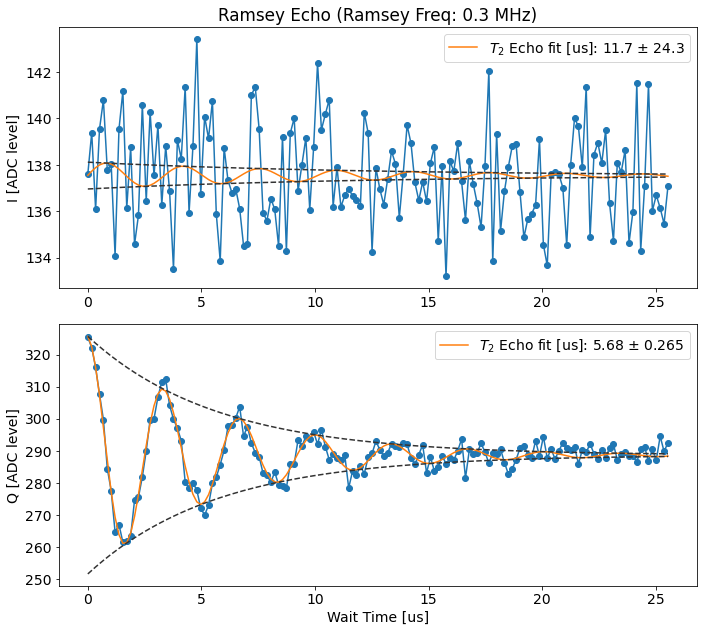

[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.626825302204, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000, 'T1': 20.27627011263198, 'T1 err': 0.5826490416084753, 'T2R': 2.583327254811115, 'T2R err': 0.1974620102484872, 'T2E': 5.663230425013751, 'T2E err': 0.2789185527767645}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [132]:
# # TESTING
# # t2e = meas.RamseyEchoExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_echo_qubit1.h5')
# t2e.data = temp_data

t2e.analyze(fit=True)

t2e_fit, t2e_fit_err, t2e_adjust = meas.fitting.get_best_fit(t2e.data, compare_param_i=3, get_best_data_params=['f_ge_adjust_ramsey'])

if not isinstance(t2e_fit, (list, np.ndarray)):
    t2e.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

t2e.display(fit=True)
results_Qi.update({'T2E':t2e_fit[3], 'T2E err':np.sqrt(t2e_fit_err[3][3])})
print(all_results)
# print('Results updated.')

In [133]:
if save_data: saved_files.append(t2e.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_echo_qubit0.h5


# Resonator chi shift (g/e)

In [120]:
rspec_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspec_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspec_chi.cfg.expt = dict(
    start=rspec_chi.cfg.device.readout.frequency[qubit_i]-span/2, # MHz
    # start=rspec_chi.cfg.device.readout.frequency[qubit_i]-rspec_chi.cfg.device.readout.lo_sideband[qubit_i]*span, # MHz
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspec_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspec_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-808.3161720994943, 5000, 1000, 0, 31.972478802377907, 338.4097714428876]

Freq with minimum transmission: -807.7532581922094
Freq with maximum transmission: -805.9320661392293
From fit:
	f0: -808.3161720994943
	Qi: 5000
	Qe: 1000
	Q0: 833.3333333333333
	kappa [MHz]: -0.9699794065193933
	phi [radians]: 0


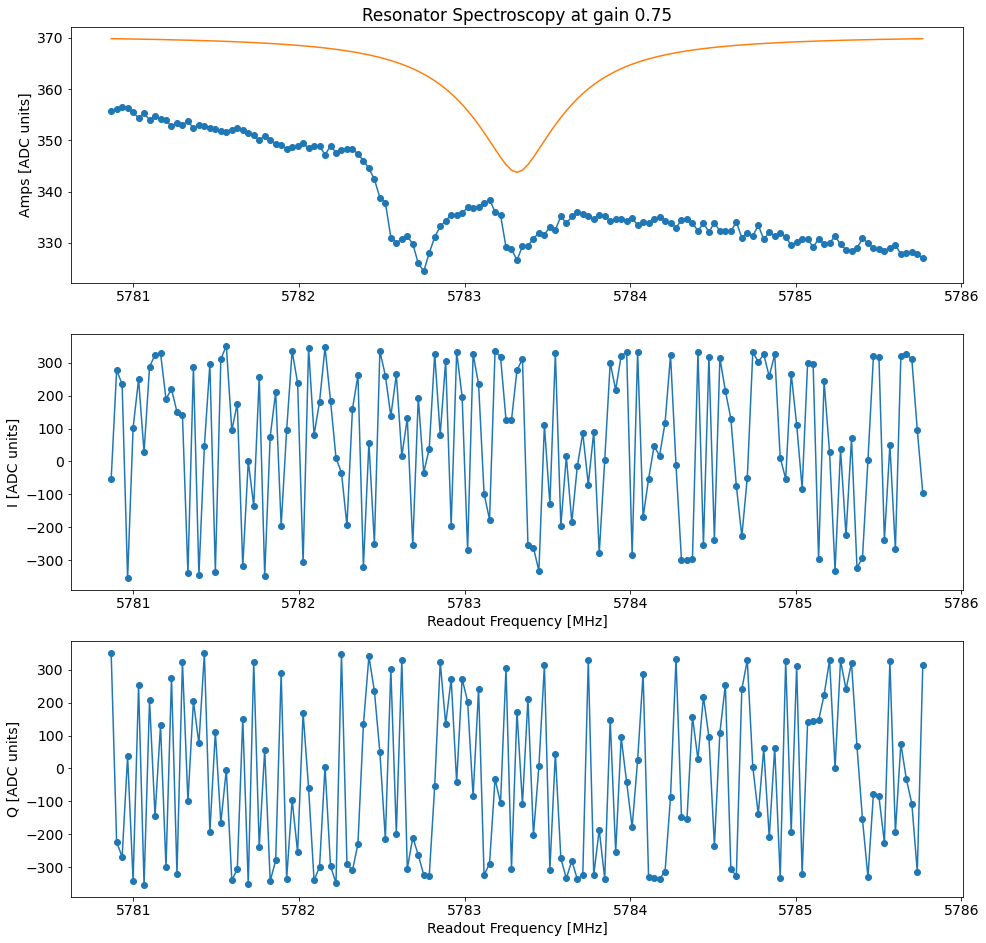

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [121]:
# # TESTING
# # rspec_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec_chi.data = temp_data

rspec_chi.analyze(fit=True)
rspec_chi_fit = rspec_chi.data['fit']
if not isinstance(rspec_chi_fit, (list, np.ndarray)):
    rspec_chi.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
rspec_chi.display(fit=True)
# res_freq_e = rspec_chi_fit[0]
res_freq_e = rspec_chi.data['xpts'][np.argmin(rspec_chi.data['amps'])]
# res_freq_e = -83
results_Qi.update({'Res chi shift (e - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_e - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_e = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [ ]:
if save_data: saved_files.append(rspec_chi.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_220919\00000_resonator_spectroscopy_chi_qubit3.h5


# Qubit ef spectroscopy

## Pulse Probe ef spectroscopy

In [134]:
qEFspec = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec.cfg = AttrDict(deepcopy(yaml_cfg))

span = 100
npts = 180

qEFspec.cfg.expt = dict(
    start=qEFspec.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=2, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    # gain=5000,
    qubit=qubit_i,
)
qEFspec.cfg.device.readout.relax_delay = qEFspec.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 628.3798192330311, HWHM 1.591045662233196
Found peak in I at [MHz] 680.7389407799147, HWHM 0.00588124198861319
Found peak in Q at [MHz] 628.3619703607203, HWHM 1.6616330866887976


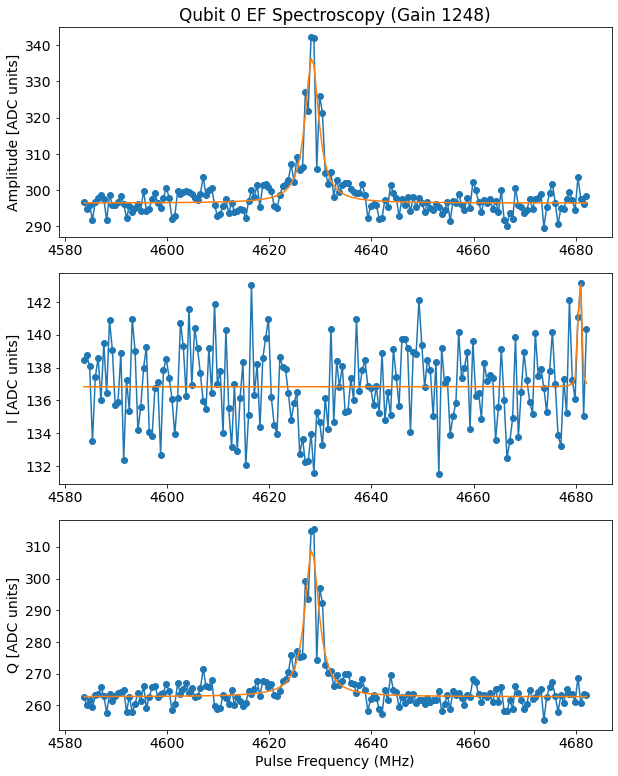

*Set qubit 0 f_ef to 628.3619703607203*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.626825302204, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000, 'T1': 20.27627011263198, 'T1 err': 0.5826490416084753, 'T2R': 2.583327254811115, 'T2R err': 0.1974620102484872, 'T2E': 5.663230425013751, 'T2E err': 0.2789185527767645, 'Qubit EF freq': 4628.36197036072}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [135]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    try: 
        qEFspec.analyze(fit=True, signs=[1, sign, sign])
        fit_err_i = qEFspec.data['fit_err_avgi'][2][2]
        fit_err_q = qEFspec.data['fit_err_avgq'][2][2]
        if fit_err_i < best_fit_err_i:
            best_signs[1] = sign
            best_fit_err_i = fit_err_i
        if fit_err_q < best_fit_err_q:
            best_signs[2] = sign
            best_fit_err_q = fit_err_q
    except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec.analyze(fit=True, signs=best_signs)
qEFspec.display(fit=True, signs=best_signs)

better_fit = (qEFspec.data['fit_avgi'], qEFspec.data['fit_avgq'])[np.argmin((qEFspec.data['fit_err_avgi'][2][2], qEFspec.data['fit_err_avgq'][2][2]))]
yaml_cfg.device.qubit.f_ef[qubit_i] = better_fit[2]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [136]:
if save_data: saved_files.append(qEFspec.save_data())

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_qubit_EF_spectroscopy_qubit0.h5


## Pulse Probe EF spectroscopy round 2

In [137]:
qEFspec2 = meas.PulseProbeEFSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)
qEFspec2.cfg = AttrDict(deepcopy(yaml_cfg))

span = 20
npts = 150

qEFspec2.cfg.expt = dict(
    start=qEFspec2.cfg.device.qubit.f_ef[qubit_i]-0.5*span, # resonator frequency to be mixed up [MHz]
    step=span/npts, # min step ~1 Hz
    expts=npts, # Number of experiments stepping from start
    reps=100, # Number of averages per point
    rounds=30, # Number of start to finish sweeps to average over
    length=4, # ef probe constant pulse length [us]
    gain=int(yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]/10), # ef pulse gain
    qubit=qubit_i,
)
qEFspec2.cfg.device.readout.relax_delay = qEFspec2.cfg.device.qubit.T1[qubit_i] # Wait time between experiments [us]
qEFspec2.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Found peak in amps at [MHz] 628.2694784951854, HWHM 3.069162560608855
Found peak in I at [MHz] 627.8665413119949, HWHM -1.0851036109547434
Found peak in Q at [MHz] 628.2522431142422, HWHM 2.9226715551548503


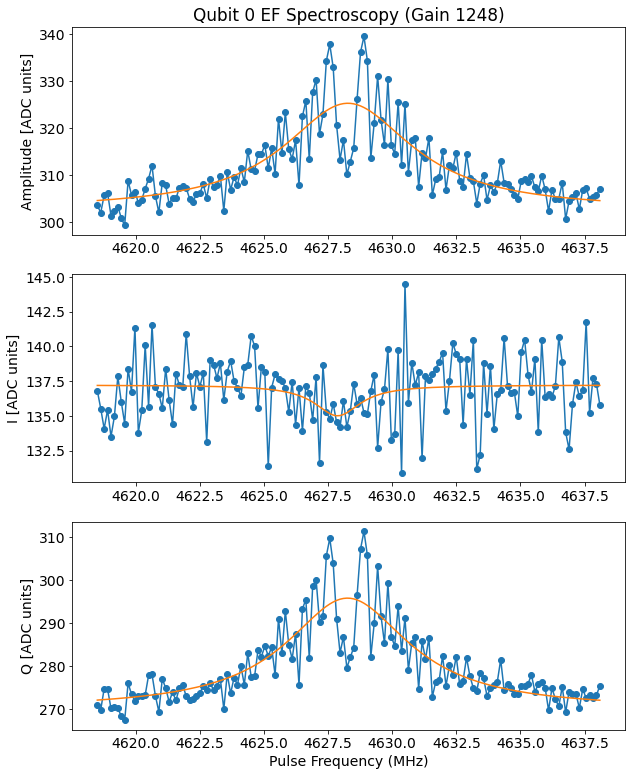

*Set qubit 0 f_ef to 628.2522431142422*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.626825302204, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000, 'T1': 20.27627011263198, 'T1 err': 0.5826490416084753, 'T2R': 2.583327254811115, 'T2R err': 0.1974620102484872, 'T2E': 5.663230425013751, 'T2E err': 0.2789185527767645, 'Qubit EF freq': 4628.252243114242}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [138]:
# # TESTING
# temp_data, attrs = prev_data(expt_path, '00000_voltage_sweep_qubit_spectroscopy_qubit3.h5')
# data = qEFspec2.analyze(data=temp_data, fit=True)

best_signs = [1, 0, 0]
best_fit_err_i = np.inf
best_fit_err_q = np.inf
for sign in [1, -1]:
    qEFspec2.analyze(fit=True, signs=[1, sign, sign])
    fit_err_i = qEFspec2.data['fit_err_avgi'][2][2]
    fit_err_q = qEFspec2.data['fit_err_avgq'][2][2]
    if fit_err_i < best_fit_err_i:
        best_signs[1] = sign
        best_fit_err_i = fit_err_i
    if fit_err_q < best_fit_err_q:
        best_signs[2] = sign
        best_fit_err_q = fit_err_q
    # except: continue
if best_fit_err_i == np.inf and best_fit_err_q == np.inf:
    qEFspec2.display(fit=False)
    assert False, 'Fit failed, please manually fix!'

qEFspec2.analyze(fit=True, signs=best_signs)
qEFspec2.display(fit=True, signs=best_signs)

qEFspec2_fit, qEFspec2_fit_err = meas.fitting.get_best_fit(qEFspec2.data, compare_param_i=2)

yaml_cfg.device.qubit.f_ef[qubit_i] = qEFspec2_fit[2]
qubitEF_hwhm = qEFspec2_fit[3]
print(f'*Set qubit {qubit_i} f_ef to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')

results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [139]:
if save_data: qEFspec2.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00001_qubit_EF_spectroscopy_qubit0.h5


## Amplitude EF Rabi

The EF pi pulse amplitude should be stored in <code>cfg.device.qubit.pulses.pi_ef.gain</code>.

In [140]:
amprabiEF = meas.AmplitudeRabiEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

amprabiEF.cfg = AttrDict(deepcopy(yaml_cfg))

span = 32000
npts = 101

amprabiEF.cfg.expt = dict(
    start=1, # qubit gain [dac level]
    step=int(span/npts), # [dac level]
    expts=npts,
    reps=100,
    rounds=30,
    sigma_test=0.025, # gaussian sigma for pulse length - default from cfg [us]
    pulse_type='gauss',
    qubit=qubit_i,
)

print(amprabiEF.cfg)
amprabiEF.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [20.0, 62.0, 46, 58], 'f_ge': [812.626825302204, 3470.1305225384785, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [628.2522431142422, 3364.2657630069557, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 22139, 22539, 28755], 'sigma': [0.03596340932991342, 0.01963196936129542, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 14667, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.644, -809.075, -79.784, 81.64542225717739], 'lo_s

  0%|          | 0/30 [00:00<?, ?it/s]

Pi gain from avgi data [dac units]: 15411
	Pi/2 gain from avgi data [dac units]: 7705
Pi gain from avgq data [dac units]: 14651
	Pi/2 gain from avgq data [dac units]: 7325


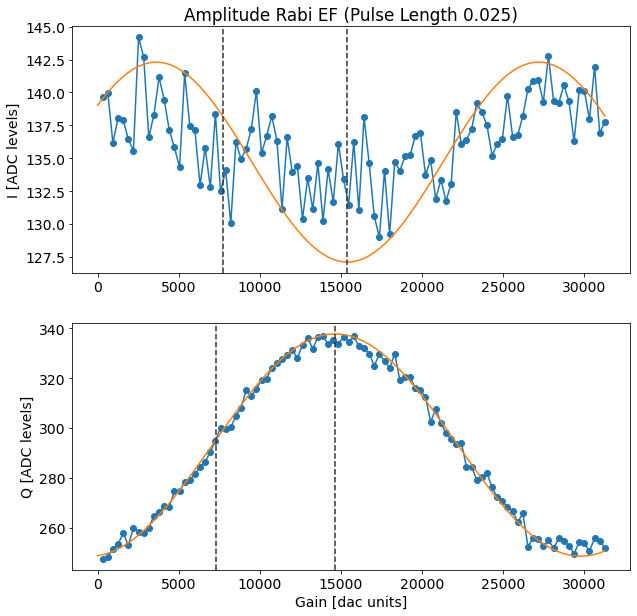

*Set EF pi pulse sigma for qubit 0 to 0.025*
*Set EF pi pulse gain for qubit 0 to 14651*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.626825302204, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000, 'T1': 20.27627011263198, 'T1 err': 0.5826490416084753, 'T2R': 2.583327254811115, 'T2R err': 0.1974620102484872, 'T2E': 5.663230425013751, 'T2E err': 0.2789185527767645, 'Qubit EF freq': 4628.252243114242, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14651}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [141]:
# TESTING
# amprabiEF = meas.AmplitudeRabiExperiment(config_file=config_path,)
# temp_data, attrs = prev_data(expt_path, '00000_amp_rabi_EF_qubit1.h5')
# amprabiEF.data = temp_data

amprabiEF.analyze(fit=True)

amprabiEF_fit, amprabiEF_fit_err = meas.fitting.get_best_fit(amprabiEF.data, compare_param_i=1)

p = amprabiEF_fit

if p[2] > 180: p[2] = p[2] - 360
elif p[2] < -180: p[2] = p[2] + 360
if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
else: pi_gain = (3/2 - p[2]/180)/2/p[1]

if pi_gain > 32000:
    amprabiEF.display(fit=False)
    print('WARNING: Fit pi pulse gain is long, please double check!')
    pi_gain = 30000
else: amprabiEF.display(fit=True)

yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i] = amprabiEF.cfg.expt.sigma_test
print(f'*Set EF pi pulse sigma for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]}*')
yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(pi_gain)
print(f'*Set EF pi pulse gain for qubit {qubit_i} to {yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]}*')
results_Qi.update({'EF pi pulse len':yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]})
results_Qi.update({'EF pi pulse gain':yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]})
print(all_results)

In [142]:
if save_data: amprabiEF.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_amp_rabi_EF_qubit0.h5


## EF Ramsey Fringe
Update the ef frequency in <code>cfg.qubit.f_ef</code>.

In [143]:
ramseyEF_freq = max(min(np.abs(np.ceil(qubitEF_hwhm)), 3), 2)

t2EFr = meas.RamseyEFExperiment(
    soccfg=soc,
    path=expt_path,
    prefix="ramseyEF"+f"_qubit{qubit_i}",
    config_file=config_path,
)

t2EFr.cfg = AttrDict(deepcopy(yaml_cfg))

t2EFr.cfg.expt = dict(
    start=0, # wait time tau [us]
    step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
    # step=0.05, # [us]
    expts=151,
    ramsey_freq=ramseyEF_freq, # [MHz]
    reps=100,
    rounds=30,
    qubit=qubit_i,
)
t2EFr.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/30 [00:00<?, ?it/s]

Attempted to init fitparam 1 to 9.099908999999998, which is out of bounds 0.023489697986577185 to 3.5234546979865775. Instead init to 1.7734721979865773
Current EF frequency: 628.2522431142422
Fit frequency from I [MHz]: 1.8416223816365083
Suggested new EF frequencies from fit avgi [MHz]:
 	629.4106207326057
 	623.4106207326057
T2 Ramsey EF from fit avgi [us]: 2.0673301605880314
Fit frequency from Q [MHz]: 3.1790947570276713
Suggested new EF frequencies from fit avgq [MHz]:
 	628.0731483572146
 	622.0731483572146
T2 Ramsey EF from fit avgq [us]: 4.29812164236544


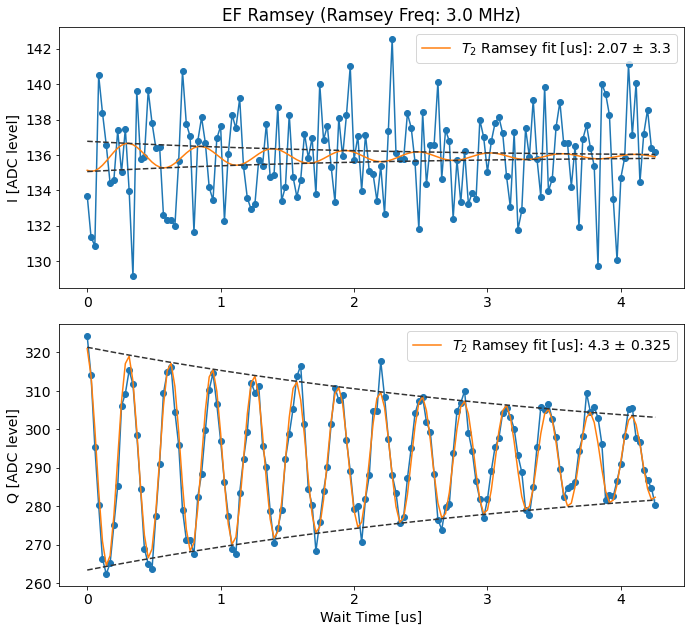

*Set qubit 0 EF freq to 628.0731483572146*
[{'Res freq': 7689.644, 'Res kappa': 0.1430146284901147, 'Qubit freq': 4812.626825302204, 'Pi pulse len': 0.03596340932991342, 'Pi pulse gain': 30000, 'T1': 20.27627011263198, 'T1 err': 0.5826490416084753, 'T2R': 2.583327254811115, 'T2R err': 0.1974620102484872, 'T2E': 5.663230425013751, 'T2E err': 0.2789185527767645, 'Qubit EF freq': 4628.073148357214, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14651}, {'Res freq': 5784.075, 'Res kappa': 0.13572611545829874, 'Qubit freq': 3470.1305225384785, 'Pi pulse len': 0.01963196936129542, 'Pi pulse gain': 22139, 'T1': 62.24918832583398, 'T1 err': 1.4809653073631912, 'T2R': 3.776382054715227, 'T2R err': 0.2928701361204788, 'T2E': 8.466685348746063, 'T2E err': 0.369701461109394, 'Qubit EF freq': 3364.2657630069557, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 14667}, {}, {}]


In [144]:
# # TESTING
# # t2EFr = meas.RamseyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_ramsey_qubit2.h5')
# t2EFr.data = temp_data

t2EFr.analyze(fit=True)
t2EFr_fit, t2EFr_fit_err, t2EFr_adjust = meas.fitting.get_best_fit(t2EFr.data, compare_param_i=3, get_best_data_params=['f_ef_adjust_ramsey'])
old_qubit_freq = t2EFr.cfg.device.qubit.f_ef

if not isinstance(t2EFr_fit, (list, np.ndarray)):
    t2EFr.display(fit=False)
    assert False, 'Fit failed, please manually fix!'
t2EFr.display(fit=True)
yaml_cfg.device.qubit.f_ef[qubit_i] = old_qubit_freq + t2EFr_adjust[0]
alt_qubit_freq = old_qubit_freq + t2EFr_adjust[1]
print(f'*Set qubit {qubit_i} EF freq to {yaml_cfg.device.qubit.f_ef[qubit_i]}*')
results_Qi.update({'Qubit EF freq':yaml_cfg.device.qubit.f_ef[qubit_i] + yaml_cfg.hw.soc.dacs.qubit.mixer_freq[qubit_i]})
print(all_results)

In [145]:
if save_data: t2EFr.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_ramseyEF_qubit0.h5


# Resonator chi shift (e/f)

In [116]:
rspecEF_chi = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_chi_qubit{qubit_i}",
    config_file=config_path,
)
rspecEF_chi.cfg = AttrDict(deepcopy(yaml_cfg))

span = 5 # MHz
npts = 151
rspecEF_chi.cfg.expt = dict(
    start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-abs(results_Qi['Res chi shift (e - g)'])-span, # [MHz]
    # start=rspecEF_chi.cfg.device.readout.frequency[qubit_i]-span/2, # [MHz]
    step=span/npts,
    expts=npts,
    reps=3000,
    pulse_e=True, # add ge pi pulse prior to measurement
    pulse_f=True, # add ef pi pulse prior to measurement
    qubit=qubit_i,
)
# rspecEF_chi.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
rspecEF_chi.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/151 [00:00<?, ?it/s]

[-811.3625297153883, 5000, 1000, 0, 17.03715941066355, 326.477619610652]
[-8.03285761e+02 -3.03561876e+05 -1.27177254e+01  5.91794716e+00
 -1.27356982e+02  3.11150862e+02]

Freq with minimum transmission: -813.4817350134015
Freq with maximum transmission: -808.9453111723419
From fit:
	f0: -803.2857613940467
	Qi: -303561.8763070908
	Qe: -12.71772541526503
	Q0: -12.717192628454415
	kappa [MHz]: 63.165337261363334
	phi [radians]: 5.917947164978501


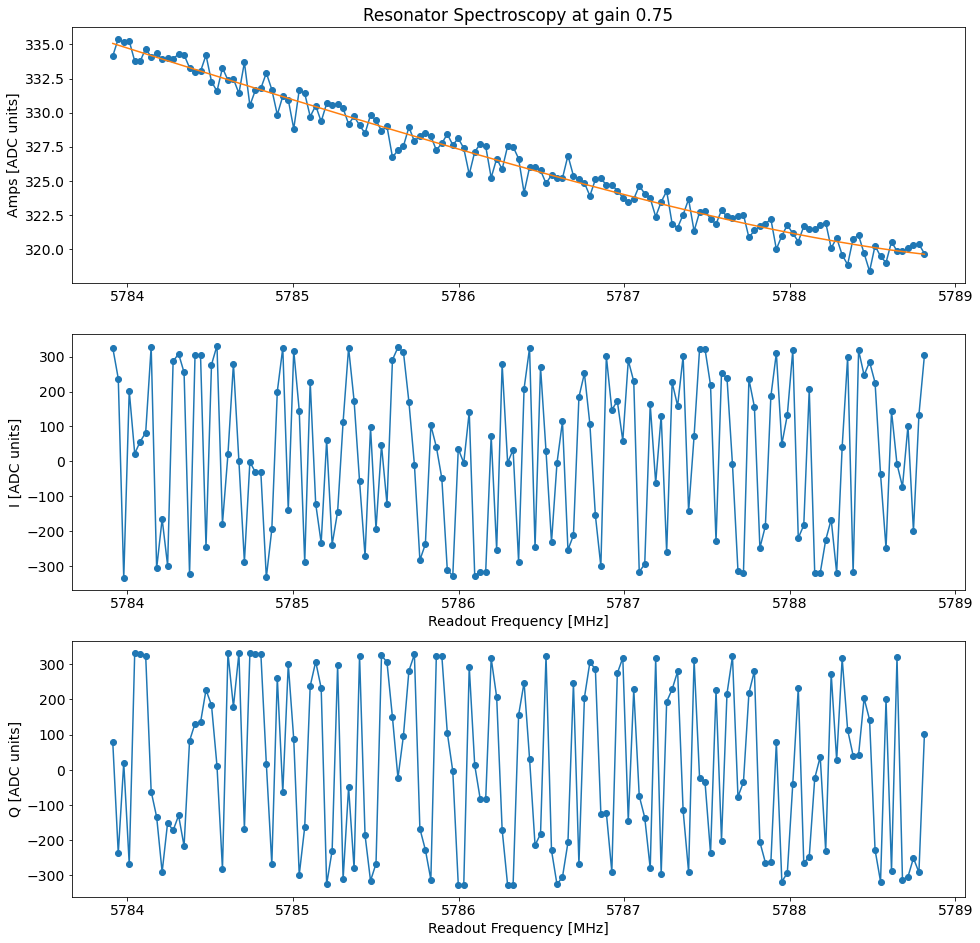

[{'Res freq': 7688.874258045896, 'Res kappa': 0.9756441096550745, 'Qubit freq': 4823.861508259508, 'Pi pulse len': 0.03956011335259716, 'Pi pulse gain': 22779, 'T1': 97.14424019836063, 'T1 err': 4.6355555889821245, 'T2R': 8.312336278065233, 'T2R err': 0.3957274632565941, 'T2E': 17.688832442781287, 'T2E err': 0.7326171278801736, 'Qubit EF freq': 4640.557961214359, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 16093}, {'Res freq': 5783.299615808103, 'Res kappa': 0.30608491399697296, 'Qubit freq': 3472.403818423059, 'Pi pulse len': 0.020738980081829388, 'Pi pulse gain': 23185, 'T1': 52.567929832315315, 'T1 err': 0.6768379550408044, 'T2R': 1.8746149564710788, 'T2R err': 0.1533478261277939, 'T2E': 15.873701812556538, 'T2E err': 0.3698073838910515, 'Res chi shift (e - g)': -0.5463576158940668, 'Qubit EF freq': 603.7170605500958, 'EF pi pulse len': 0.025, 'EF pi pulse gain': 2680, 'Res chi shift (f - g)': 5.546357615894067}, {}, {}]


In [117]:
# # TESTING
# # rspecEF_chi = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspecEF_chi.data = temp_data

rspecEF_chi.analyze(fit=True)
rspecEF_chi_fit = rspecEF_chi.data['fit']
rspecEF_chi.display(fit=True)
# res_freq_f = rspecEF_chi_fit[0]
res_freq_f = rspecEF_chi.data['xpts'][np.argmin(rspecEF_chi.data['amps'])]
results_Qi.update({'Res chi shift (f - g)': yaml_cfg.device.readout.lo_sideband[qubit_i]*(res_freq_f - yaml_cfg.device.readout.frequency[qubit_i])})
# res_freq_f = 6953.5
# results_Qi.update({'Res chi shift (e - g)': res_freq_e - (5925 + yaml_cfg.device.readout.lo_sideband[qubit_i]*(yaml_cfg.hw.soc.dacs.readout.mixer_freq + yaml_cfg.device.readout.frequency[qubit_i]))})
print(all_results)

In [118]:
if save_data: rspecEF_chi.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_resonator_spectroscopy_chi_qubit1.h5


# Single Shot

## Single shot optimization

In [50]:
results_Qi['Res kappa'] = 0.306/2

In [151]:
shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

# span_f = 2*abs(results_Qi['Res chi shift (f - g)']) # MHz
# span_f = 2*abs(results_Qi['Res chi shift (e - g)']) # MHz
span_f = 2*abs(results_Qi['Res kappa']) # MHz
npts_f = 15

span_gain = 0.95
npts_gain = 5

span_len = 10 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=20000,
    qubit=qubit_i,

    # start_f=shotopt.cfg.device.readout.frequency[qubit_i] - 0.75*span_f,
    start_f=shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,

    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i] - 0.5*span_gain),
    # start_gain=int(shotopt.cfg.device.readout.gain[qubit_i]-span_gain/2),
    # start_gain=0.200,
    start_gain=0.1,
    step_gain=span_gain/npts_gain,
    expts_gain=npts_gain,

    start_len=10,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

print(shotopt.cfg)

shotopt.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [20.0, 62.0, 46, 58], 'f_ge': [812.626825302204, 3470.1305225384785, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [628.0731483572146, 3364.2657630069557, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 22139, 22539, 28755], 'sigma': [0.03596340932991342, 0.01963196936129542, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [14651, 14667, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.644, -809.075, -79.784, 81.64542225717739], 'lo_s

  0%|          | 0/15 [00:00<?, ?it/s]

freq: 814.5009853715098, gain: 0.1, len: 10.0
	fid ge [%]: 0.8750218755468886
freq: 814.5009853715098, gain: 0.29000000000000004, len: 10.0
	fid ge [%]: 1.3950348758718967


KeyboardInterrupt: 

(11, 3, 0)
[814.50098537 814.52005399 814.53912261 814.55819122 814.57725984
 814.59632846 814.61539707 814.63446569 814.65353431 814.67260293
 814.69167154 814.71074016 814.72980878 814.74887739 814.76794601]
[0.1  0.29 0.48 0.67 0.86]
[10.]
Max fidelity 0.019450972548627432
Set params: 
 angle (deg) 57.220235762603075 
 threshold 113.89453476025358 
 freq [Mhz] 814.710740159962 
 gain [dac units] 0.67 
 readout length [us] 10.0


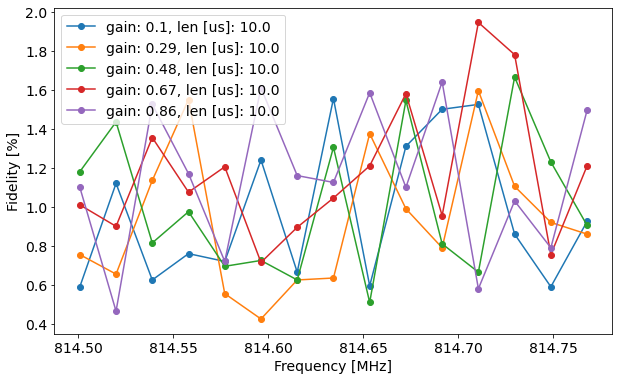

[[[0.00590015]
  [0.00755019]
  [0.01180059]
  [0.01010025]
  [0.01100028]]

 [[0.01120056]
  [0.00655016]
  [0.01435036]
  [0.00900023]
  [0.00465012]]

 [[0.00625031]
  [0.01135057]
  [0.0081502 ]
  [0.01355034]
  [0.01525038]]

 [[0.00760019]
  [0.01550039]
  [0.00975049]
  [0.01075027]
  [0.01170117]]

 [[0.00720018]
  [0.00555014]
  [0.00695017]
  [0.0120503 ]
  [0.00720018]]

 [[0.01240031]
  [0.00425011]
  [0.00725018]
  [0.00715018]
  [0.0161004 ]]

 [[0.00665033]
  [0.00625016]
  [0.00625031]
  [0.00895022]
  [0.01160087]]

 [[0.01555039]
  [0.00635016]
  [0.01305033]
  [0.01045026]
  [0.01125113]]

 [[0.0059503 ]
  [0.01375034]
  [0.00510013]
  [0.0121003 ]
  [0.01585119]]

 [[0.01310033]
  [0.00990025]
  [0.01545077]
  [0.0158004 ]
  [0.01100028]]

 [[0.01500038]
  [0.0079004 ]
  [0.0081002 ]
  [0.00955048]
  [0.01640041]]

 [[0.01525038]
  [0.0159504 ]
  [0.00665017]
  [0.01945097]
  [0.00580015]]

 [[0.00860022]
  [0.01105028]
  [0.01665042]
  [0.01780045]
  [0.01030026]]


In [147]:
imax = shotopt.analyze()
shotopt.display()
print(shotopt.data['fid'])

freq_opt = shotopt.data['fpts'][imax[0]]
gain_opt = shotopt.data['gainpts'][imax[1]]
len_opt = shotopt.data['lenpts'][imax[2]]

In [96]:
if save_data: shotopt.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221020\00000_single_shot_opt_qubit1.h5


## Best readout parameters

In [148]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)
shot.cfg = AttrDict(deepcopy(yaml_cfg))

shot.cfg.expt = dict(
    reps=30000,
    check_f=False,
    qubit=qubit_i,
)

# shot.cfg.device.readout.frequency=freq_opt
# shot.cfg.device.readout.gain=gain_opt
# shot.cfg.device.readout.readout_length = len_opt # [us]

# shot.cfg.device.readout.frequency=-807.4996158081035
# shot.cfg.device.readout.gain=0.600
# shot.cfg.device.readout.readout_length = 7 # [us]
# shot.cfg.device.readout.relax_delay = 70 # Wait time between experiments [us]
print(shot.cfg)

shot.go(analyze=False, display=False, progress=True, save=False)

{'device': {'qubit': {'T1': [20.0, 62.0, 46, 58], 'f_ge': [812.626825302204, 3470.1305225384785, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [628.0731483572146, 3364.2657630069557, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [30000, 22139, 22539, 28755], 'sigma': [0.03596340932991342, 0.01963196936129542, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [14651, 14667, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.644, -809.075, -79.784, 81.64542225717739], 'lo_s

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

Unrotated:
Ig -103.92320208265538 +/- 122.29718824435987 	 Qg 269.14415880247316 +/- 121.3380810424146 	 Amp g 288.51102257730696
Ie -159.2723722746502 +/- 124.8435215480358 	 Qe 321.69720143182553 +/- 123.02618614297039 	 Amp e 358.9662630095805
Rotated:
Ig 260.9202732276642 +/- 122.29718824435987 	 Qg -122.31531873531674 +/- 121.3380810424146 	 Amp g 288.16735793375534
Ie 337.15802703938505 +/- 124.8435215480358 	 Qe -124.39343360833169 +/- 123.02618614297039 	 Amp e 359.3734290705994


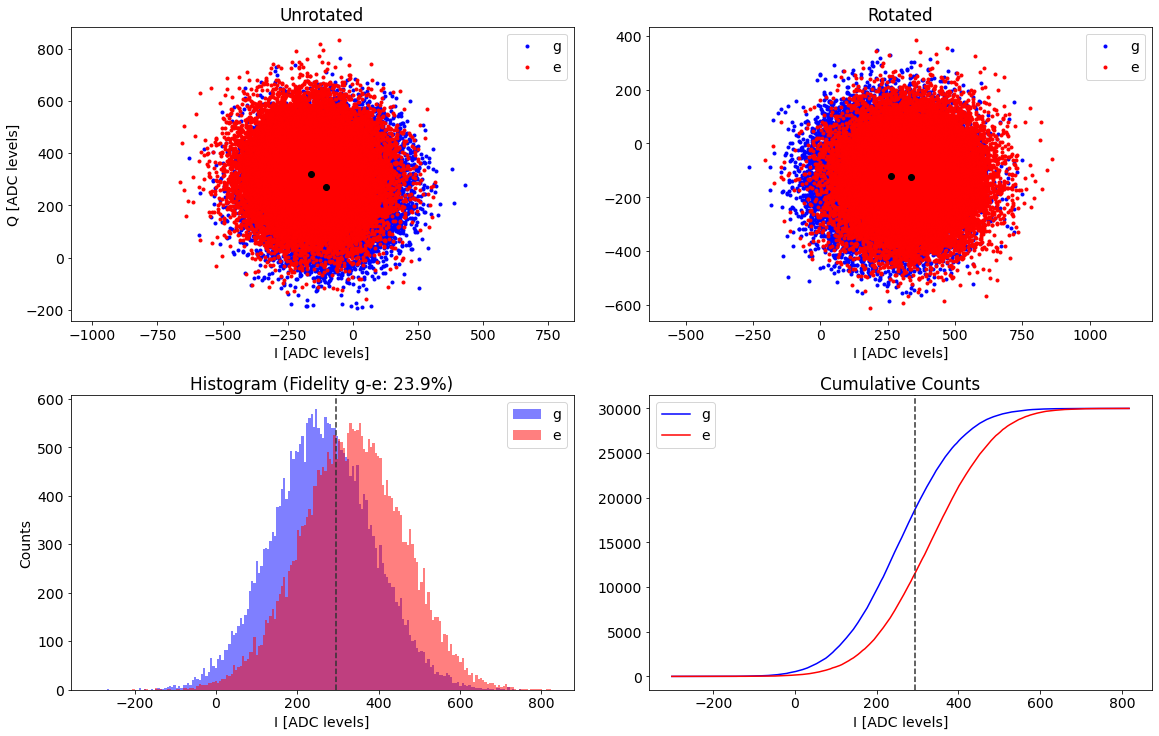

ge fidelity (%): 23.861193059652983
rotation angle (deg): -136.48440387331246
threshold ge: 294.6700394857735


In [150]:
# # TESTING
# shot = meas.HistogramExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00001_single_shot_qubit0.h5')
# data = shot.analyze(data=temp_data)
# shot.display(data=data)

shot.analyze(verbose=False)
shot.display(verbose=True)

In [151]:
if save_data: shot.save_data()

Saving s:\Connie\experiments\qramLL_4QR2\data_221007\00000_single_shot_qubit1.h5


# Results

In [99]:
print(yaml_cfg)
for Qi, results in enumerate(all_results):
    print(f'Qubit {Qi}')
    for key, value in results.items():
        print(f'\t{key}: {value}')
    print()

{'device': {'qubit': {'T1': [97, 62.0, 46, 58], 'f_ge': [823.0681204610527, 3470.1305225384785, 153.92796237453135, 447.5819924260869], 'f_Q1_ZZ': [3468.889513688846, 3470.20476419, 3465.25270434, 3469.12083078], 'f_ef': [633.210668158286, 3364.2657630069557, -71.90192894145498, 275.76433968698353], 'f_EgGf': [2009.95, 3364.24341488, 2683.62545251, 2389.97142246], 'gs': [43, 0, 54, 40], 'pulses': {'pi_ge': {'gain': [22692, 22139, 22539, 28755], 'sigma': [0.0386, 0.01963196936129542, 0.0433, 0.0276], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_ef': {'gain': [12488, 14667, 20765, 29402], 'sigma': [0.025, 0.025, 0.035, 0.015], 'type': 'gauss'}, 'pi_Q1_ZZ': {'gain': [25000, 0, 25000, 25000], 'sigma': [0.0174, 0, 0.016, 0.0175], 'type': ['gauss', 'gauss', 'gauss', 'gauss']}, 'pi_EgGf': {'gain': [3450, 0, 2750, 2850], 'sigma': [0.2186, 0, 0.232, 0.29], 'type': 'const'}}}, 'readout': {'trig_offset': 125, 'frequency': [814.069, -809.075, -79.784, 81.64542225717739], 'lo_sideband': [1, -